In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import random
from sklearn.utils import resample
from sklearn.externals import joblib
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# IMPORT DATA

In [2]:
#import Pickled Data

X_train = pickle.load(open("X_train_features.pkl", 'rb'))
y_train = pickle.load(open("y_train_features.pkl", 'rb'))
X_validation = pickle.load(open("X_validation_features.pkl", 'rb'))
y_validation = pickle.load(open("y_validation_features.pkl", 'rb'))
X_test = pickle.load(open("X_test_features.pkl", 'rb'))



X_train_pay = pickle.load(open("X_train_pay.pkl", 'rb'))

Lin_features = pickle.load(open('bestFeatures.pkl', 'rb'))


In [3]:
#import unprocessed original data

traindf = pd.read_csv("train.csv")
validationdf = pd.read_csv("validation.csv")
testdf = pd.read_csv("test.csv")


In [4]:
#Liimit the input data by the feature columns

feature_X_train = X_train[Lin_features].values
feature_X_val = X_validation[Lin_features].values
feature_X_test = X_test[Lin_features].values

#print(len(X_validation.columns))

In [ ]:
#print(str(len(Lin_features)) + " of the original " + str(len(X_train.columns)) + " are now being used")

240 of the original 580 are now being used


In [5]:
'''
Creating the necessary variables for the the average CTR 
and the range which will be used to test the base bid
'''
avgCTR = traindf["click"].sum()*100/traindf.shape[0]
bid_list = list(range(traindf.loc[traindf["click"] == 1, "payprice"].min(),300, 5))


avgBid_training = traindf.loc[traindf["click"] == 1, "payprice"].mean()
print("In the training data, the average CTR is: %.4f , and the average BID is: $%.2f"
      % (avgCTR, avgBid_training))


In the training data, the average CTR is: 0.0738 , and the average BID is: $105.46


In [6]:
'''
Use logistic regression to model the training data for clicks.
Get the probablility of each row getting a click for both the validation and test dataset
'''

click_clf = LogisticRegression(C = 0.1, random_state = 123)
click_clf.fit(feature_X_train, y_train)


predict_proba_list_val = click_clf.predict_proba(feature_X_val)

predict_proba_list_test = click_clf.predict_proba(feature_X_test)


validationdf['click_proba'] = [item[1] for item in predict_proba_list_val]
testdf['click_proba'] = [item[1] for item in predict_proba_list_test]
testdf['click'] = click_clf.predict(feature_X_test)



In [7]:
testdf.groupby(['click'])[['click']].count()

,click
click,
0,302016
1,1359


In [17]:
'''
Linear bidding which bids on each row based on the mulipication of the base bid 
by the row's likeliness of getting a click, divided by the avg CTR'''


def lin_bid(base_bid, df, budget = 6250000):
    
    bid = (base_bid * df["click_proba"]) / avgCTR
        
    counter = 0
    clicks = 0
    imp = 0
    spent = 0
    
    while ((budget >= 0) & (counter < len(df))):

        if(df['payprice'][counter] < bid[counter]):
            budget -= df['payprice'][counter]
            spent += df["payprice"][counter]
            clicks += df['click'][counter]
            imp += 1
            
        counter += 1
        
    ctr = clicks/imp
    cpm = spent/imp
    cpc = spent/clicks/1000
    spent = round(spent/6250000 *100)
    
    
    return clicks, ctr, spent, cpm, cpc, imp, bid

In [9]:
def run_lin_bid_model(df):
    clicks_list = []
    imp_list = []

    for bid in bid_list:

        clicks, ctr, spent, cpm, cpc, imp = lin_bid(bid, df)
        print("Bidding $ %s scores:: %s clicks, %.5f ctr, %s spent, %.2f cpm, %.2f cpc, %s imp"  
              % (bid, clicks, ctr, spent, cpm, cpc, imp))
        clicks_list.append(clicks)
        imp_list.append(imp)  

    plt.figure(figsize = (10,8))

    plt.subplot(3,1,1)
    plt.plot(bid_list, imp_list, "b-" )
    plt.xlabel("Base Bid")
    plt.ylabel("# of Impressions")
    plt.show()

    plt.figure(figsize = (10,8))

    plt.subplot(3,1,1)
    plt.plot(bid_list, clicks_list, "r")

    plt.xlabel("Base Bid")
    plt.ylabel("# of Clicks")
    plt.show()

# PREDICT THE VALIDATION DATAFRAME

Bidding $ 4 scores:: 7 clicks, 0.00241 ctr, 0.0 spent, 8.00 cpm, 3.31 cpc, 2900 imp
Bidding $ 9 scores:: 39 clicks, 0.00405 ctr, 2.0 spent, 14.08 cpm, 3.48 cpc, 9623 imp
Bidding $ 14 scores:: 60 clicks, 0.00344 ctr, 5.0 spent, 18.27 cpm, 5.31 cpc, 17448 imp
Bidding $ 19 scores:: 73 clicks, 0.00283 ctr, 9.0 spent, 22.09 cpm, 7.82 cpc, 25837 imp
Bidding $ 24 scores:: 82 clicks, 0.00234 ctr, 14.0 spent, 25.26 cpm, 10.80 cpc, 35053 imp
Bidding $ 29 scores:: 96 clicks, 0.00215 ctr, 20.0 spent, 27.78 cpm, 12.92 cpc, 44628 imp
Bidding $ 34 scores:: 103 clicks, 0.00192 ctr, 26.0 spent, 29.97 cpm, 15.65 cpc, 53776 imp
Bidding $ 39 scores:: 115 clicks, 0.00183 ctr, 32.0 spent, 31.92 cpm, 17.44 cpc, 62835 imp
Bidding $ 44 scores:: 119 clicks, 0.00166 ctr, 39.0 spent, 33.90 cpm, 20.38 cpc, 71527 imp
Bidding $ 49 scores:: 122 clicks, 0.00152 ctr, 46.0 spent, 35.84 cpm, 23.53 cpc, 80092 imp
Bidding $ 54 scores:: 128 clicks, 0.00145 ctr, 53.0 spent, 37.53 cpm, 25.90 cpc, 88352 imp
Bidding $ 59 scores

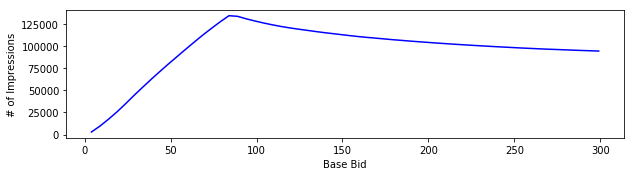

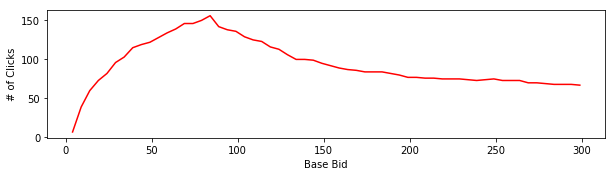

In [10]:
run_lin_bid_model(validationdf)

In [10]:
bid = 85
clicks, ctr, spent, cpm, cpc, imp = lin_bid(bid, validationdf)
print("THE BEST BID IS")
print("Bidding $ %s scores:: %s clicks, %.5f ctr, %s spent, %.2f cpm, %.2f cpc, %s imp"  
      % (bid, clicks, ctr, spent, cpm, cpc, imp))


THE BEST BID IS
Bidding $ 85 scores:: 157 clicks, 0.00116 ctr, 100.0 spent, 46.04 cpm, 39.76 cpc, 135587 imp


In [31]:
###Multi-agent evaluation method###

import heapq
def evaluate_mult(agent_bids, budget = 6250000):
    
    agent_num = len(agent_bids)
    counter = 0
    clicks = [0] * agent_num
    imp =[0] * agent_num
    spent = [0] * agent_num
    agent_budget = [budget] * agent_num

    while ((any(x > 0 for x in agent_budget)) & (counter < len(validationdf))):
        #assign current round of bids to one array
        curr_bids = [item[counter] for item in agent_bids]
        #check for budget; if agent runs out of budget, set current round's bid to 0
        for i in range(agent_num):
            #set their bid to 0 if they run out of budget
            if agent_budget[i] <= 0:
                curr_bids[i] = 0

        if(any(y >= validationdf['payprice'][counter] for y in curr_bids)):
            #add payprice to list of bid prices to compare
            curr_bids.append(validationdf['payprice'][counter])
            #deduct second price from winning bid's budget
            agent_budget[curr_bids.index(max(curr_bids))] -= heapq.nlargest(2, curr_bids)[1]
            #return bid results
            clicks[curr_bids.index(max(curr_bids))] += validationdf['click'][counter]
            spent[curr_bids.index(max(curr_bids))] += validationdf["payprice"][counter]
            imp[curr_bids.index(max(curr_bids))] += 1
        counter += 1
        
    #ctr = clicks/imp
    #cpm = spent/imp
    #cpc = spent/clicks/1000
    spent = round(spent/6250000 *100)
    
    
    return clicks, spent, imp

In [19]:
# testing the multi-agent evaluation method by using 2 temp bid methods with base_bid = 85 and base_bid = 84
bid_85 = lin_bid(bid, validationdf)[6]
bid_84 = lin_bid(84, validationdf)[6]

In [21]:
curr_res = evaluate_mult([bid_85, bid_84])

In [43]:
def print_results(evaluation):
    agent_num = len(evaluation[0])
    agents_ctr = [0] * agent_num
    agents_cpm = [0] * agent_num
    agents_cpc = [0] * agent_num
    for i in range(agent_num):
        agents_ctr[i] = evaluation[0][i] / evaluation[2][i]
        agents_cpm[i] = evaluation[1][i] / evaluation[2][i]
        agents_cpc[i] = evaluation[1][i] / evaluation[0][i] / 1000
    
    print("Agent clicks: ", evaluation[0])
    print("Agent spending: ", evaluation[1])
    print("Agent impressions: ", evaluation[2])
    print("Agent CTRs: ", agents_ctr)
    print("Agent CPMs: ", agents_cpm)
    print("Agent CPCs: ", agents_cpc)

In [44]:
print_results(curr_res)

Agent clicks:  [61, 95]
Agent spending:  [2556442, 3632913]
Agent impressions:  [55478, 79294]
Agent CTRs:  [0.0010995349507913047, 0.001198072994173582]
Agent CPMs:  [46.08028407657089, 45.8157363734961]
Agent CPCs:  [41.908885245901644, 38.24118947368421]


# PREDICT THE TEST DATAFRAME

In [ ]:
# Create a predicted pay price for the test dataframe


'''
Use logistic regression to model the training data for pay price.
Get the probablility of each row getting a click for both the validation and test dataset
'''


prices_clf = LogisticRegression(C = 0.1, random_state = 123)
prices_clf.fit(X_train_pay[Lin_features].values, X_train_pay['payprice'])

testdf['payprice'] = prices_clf.predict(feature_X_test)


In [ ]:
np.setdiff1d(X_train_pay[Lin_features],X_test[Lin_features])

In [ ]:
run_lin_bid_model(testdf)

In [11]:
agent_bids = [[3,4,5],[6,7,8]]

In [15]:
[item[0] for item in agent_bids]

[3, 6]